In [ ]:
import argparse
import logging
import math
import os
import random
from pathlib import Path
from typing import Optional

import accelerate
import numpy as np
import torch
import torch.nn.functional as F
import torch.utils.checkpoint
import transformers
from accelerate import Accelerator
from accelerate.logging import get_logger
from accelerate.utils import ProjectConfiguration, set_seed
from datasets import load_dataset, Dataset
from huggingface_hub import HfFolder, Repository, create_repo, whoami
from packaging import version
from PIL import Image
from torchvision import transforms
from tqdm.auto import tqdm
from transformers import AutoTokenizer, PretrainedConfig

import diffusers
from diffusers import (
    AutoencoderKL,
    ControlNetModel,
    DDPMScheduler,
    StableDiffusionControlNetPipeline,
    UNet2DConditionModel,
    UniPCMultistepScheduler,
)

from diffusers.optimization import get_scheduler
from diffusers.utils import check_min_version, is_wandb_available
from diffusers.utils.import_utils import is_xformers_available

# Test Dataset

In [23]:
dataset = load_dataset('json', data_files=["/home/v-yuancwang/DiffAudioImg/metadata/vgg_train_0.json",
                                           "/home/v-yuancwang/DiffAudioImg/metadata/vgg_train_1.json",
                                           "/home/v-yuancwang/DiffAudioImg/metadata/vgg_train_2.json",
                                           "/home/v-yuancwang/DiffAudioImg/metadata/vgg_train_3.json",
                                           "/home/v-yuancwang/DiffAudioImg/metadata/vgg_train_4.json"])
dataset

Found cached dataset json (/home/v-yuancwang/.cache/huggingface/datasets/json/default-73ecdd905f25d3ca/0.0.0/fe5dd6ea2639a6df622901539cb550cf8797e5a6b2dd7af1cf934bed8e233e6e)


  0%|          | 0/1 [00:00<?, ?it/s]

DatasetDict({
    train: Dataset({
        features: ['image', 'conditioning_mel', 'text'],
        num_rows: 818162
    })
})

# Test ControlNet Format

In [2]:
pretrained_model_name_or_path = "runwayml/stable-diffusion-v1-5"

In [ ]:
# Load scheduler and models
noise_scheduler = DDPMScheduler.from_pretrained(pretrained_model_name_or_path, subfolder="scheduler")
vae = AutoencoderKL.from_pretrained(pretrained_model_name_or_path, subfolder="vae")
unet = UNet2DConditionModel.from_pretrained(
    pretrained_model_name_or_path, subfolder="unet"
)

In [ ]:
controlnet = ControlNetModel.from_unet(unet)

In [27]:
latents = vae.encode(dataset[0]["pixel_values"].reshape(1,3,256,256)).latent_dist.sample()
latents = latents * vae.config.scaling_factor
print(latents.shape)

# Sample noise that we'll add to the latents
noise = torch.randn_like(latents)
bsz = latents.shape[0]
# Sample a random timestep for each image
timesteps = torch.randint(0, noise_scheduler.config.num_train_timesteps, (bsz,), device=latents.device)
timesteps = timesteps.long()

# Add noise to the latents according to the noise magnitude at each timestep
# (this is the forward diffusion process)
noisy_latents = noise_scheduler.add_noise(latents, noise, timesteps)

# Get the text embedding for conditioning
encoder_hidden_states = torch.zeros((1, 77, 768))

controlnet_image = dataset[0]["conditioning_pixel_values"].reshape(1,3,256,256)

down_block_res_samples, mid_block_res_sample = controlnet(
    noisy_latents,
    timesteps,
    encoder_hidden_states=encoder_hidden_states,
    controlnet_cond=controlnet_image,
    return_dict=False,
    )

# Predict the noise residual
model_pred = unet(
    noisy_latents,
    timesteps,
    encoder_hidden_states=encoder_hidden_states,
    down_block_additional_residuals=down_block_res_samples,
    mid_block_additional_residual=mid_block_res_sample,
    ).sample

print(model_pred.shape)

torch.Size([1, 4, 32, 32])
torch.Size([1, 4, 32, 32])


# Test Inference Pipeline

In [1]:
from diffusers import StableDiffusionControlNetPipeline
from diffusers.utils import load_image

# Let's load the popular vermeer image
image = load_image(
    "https://hf.co/datasets/huggingface/documentation-images/resolve/main/diffusers/input_image_vermeer.png"
)

In [2]:
import cv2
from PIL import Image
import numpy as np

image = np.array(image)

low_threshold = 100
high_threshold = 200

image = cv2.Canny(image, low_threshold, high_threshold)
image = image[:, :, None]
image = np.concatenate([image, image, image], axis=2)
canny_image = Image.fromarray(image)

In [ ]:
from diffusers import StableDiffusionControlNetPipeline, ControlNetModel
import torch

controlnet = ControlNetModel.from_pretrained("lllyasviel/sd-controlnet-canny")
pipe = StableDiffusionControlNetPipeline.from_pretrained(
    "runwayml/stable-diffusion-v1-5", controlnet=controlnet
)

In [4]:
from diffusers import UniPCMultistepScheduler, PNDMScheduler

pipe.scheduler = PNDMScheduler.from_config(pipe.scheduler.config)

# this command loads the individual model components on GPU on-demand.
pipe.enable_model_cpu_offload()

In [ ]:
generator = torch.manual_seed(1342)

out_image = pipe(
    "Dragon magic girl", num_inference_steps=100, generator=generator, image=canny_image, guidance_scale=8, width=512, height=512
).images[0]

out_image

In [8]:
import os

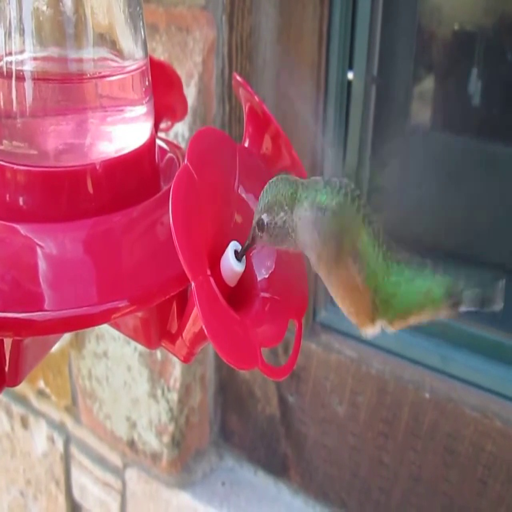

In [17]:
img_path = "/blob/v-yuancwang/DiffAudioImg/VGGSound/data/vggsound/img_spilt"
img = Image.open(os.path.join(img_path, "2/--UQXuZfbFY_44000_54000_2.jpg"))
img = img.resize((512, 512))
img

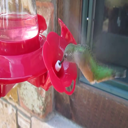

In [18]:
img = img.resize((128, 128))
img